# Imports and utility

In [1]:
#d8f53b61969adf7ee621c216f680b707
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras_hub
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Activation, GlobalAveragePooling2D)
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet152, EfficientNetB0, DenseNet121, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import optimizers

train_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/train'
val_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/val'
test_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/test'
auto_test = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test'
cat_dir = '/kaggle/input/cat-knee/clean'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 66


In [2]:
import pandas as pd
import os

def create_dataframe_from_directory(base_dir, regression=False):
    data = []
    for label_str in sorted(os.listdir(base_dir)):
        label_path = os.path.join(base_dir, label_str)
        if not os.path.isdir(label_path):
            continue
        label = float(label_str) if regression else label_str
        for fname in os.listdir(label_path):
            data.append({
                'filename': os.path.join(label_str, fname),  # ruta relativa
                'label': label  # KL debe ser numérico para regresión
            })
    return pd.DataFrame(data)

In [3]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

cat_generator = val_test_datagen.flow_from_directory(
    cat_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


train_df = create_dataframe_from_directory(train_dir)
val_df = create_dataframe_from_directory(val_dir)
test_df = create_dataframe_from_directory(test_dir)
cat_df = create_dataframe_from_directory(cat_dir)

datagen = ImageDataGenerator(rescale=1./255)

train_generator_reg = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,  # importante
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='raw',
    shuffle=True
)

val_generator_reg = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=val_dir,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='raw',
    shuffle=False
)

cat_generator_reg = datagen.flow_from_dataframe(
    dataframe=cat_df,
    directory=cat_dir,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='raw',
    shuffle=False
)



Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.
Found 83 images belonging to 5 classes.
Found 5778 validated image filenames.
Found 826 validated image filenames.
Found 83 validated image filenames.


In [4]:
from sklearn.metrics import mean_absolute_error, accuracy_score
import numpy as np
import tensorflow as tf

class CatValidationCallback(tf.keras.callbacks.Callback):
    def __init__(self, cat_generator, regresion=False, filepath='best_model_cat.keras'):
        super().__init__()
        self.cat_generator = cat_generator
        self.epoch_metrics = []
        self.regresion = regresion
        self.filepath = filepath
        # Inicializamos best_score y best_loss
        if regresion:
            self.best_score = 0.0    # queremos maximizar accuracy
            self.best_loss  = np.inf # y minimizar MAE
        else:
            self.best_score = 0.0    # queremos maximizar accuracy
            self.best_loss  = np.inf # y minimizar categorical loss

    def on_epoch_end(self, epoch, logs=None):
        # Predicciones
        preds = self.model.predict(self.cat_generator, verbose=0)

        if self.regresion:
            # Regresión: calculamos MAE + accuracy sobre clases redondeadas
            y_pred = preds.flatten()
            y_true = self.cat_generator.labels
            loss = mean_absolute_error(y_true, y_pred)
            y_pred_class = np.clip(np.round(y_pred), 0, 4).astype(int)
            y_true_class = np.clip(np.round(y_true), 0, 4).astype(int)
            acc = accuracy_score(y_true_class, y_pred_class)
            score = acc
        else:
            # Clasificación: evalúa el loss y la accuracy
            loss, acc = self.model.evaluate(self.cat_generator, verbose=0)
            preds_class = np.argmax(preds, axis=1)
            y_true = self.cat_generator.classes
            # para consistency, recalculamos acc con sklearn
            acc = accuracy_score(y_true, preds_class)
            score = acc

        # Guardar métricas
        self.epoch_metrics.append({
            'epoch': epoch + 1,
            'val_cat_loss': loss,
            'val_cat_accuracy': acc
        })

        # Mostrar por consola
        tag = "MAE" if self.regresion else "Loss"
        print(f"🐾 [Cat Val] {tag}: {loss:.4f} | Accuracy: {acc:.4f}")

        # Comprobamos mejora: primero por score, si empate por loss
        improved = False
        if score > self.best_score:
            improved = True
        elif score == self.best_score and loss < self.best_loss:
            improved = True

        # Si mejoró, guardamos modelo y actualizamos referencias
        if improved:
            self.best_score = score
            self.best_loss  = loss
            self.model.save(self.filepath)
            print(f"📦 Modelo mejorado guardado en {self.filepath}")


In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint

def get_callbacks(regression=False, cat_gen=None):
  cat_val_cb = CatValidationCallback(cat_gen, regresion=regression)
  

  checkpoint_cb = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',         # nombre de la métrica a monitorizar
    mode='max',                     # porque buscamos la mayor precisión
    save_best_only=True,
    save_weights_only=False,
    verbose=1
  )
  checkpoint_cb_reg = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
  )
  if regression:
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
        cat_val_cb,
        checkpoint_cb_reg
    ]
  else:
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
        cat_val_cb,
        checkpoint_cb
    ]
  return callbacks


In [6]:
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def _get_label_map(y_true, y_pred, generator=None, default_prefix='KL'):
    """
    Genera label_map automáticamente.
    - Si el generador tiene class_indices (clasificación Keras), los usa.
    - Si no, extrae las clases únicas de y_true y y_pred.
    - Si todo falla, crea labels 'KL 0', 'KL 1', ..., según número de clases.
    """
    # Caso Keras classification_generator
    if generator is not None and hasattr(generator, 'class_indices'):
        # Ordenar por índice
        sorted_items = sorted(generator.class_indices.items(), key=lambda x: x[1])
        return [name for name, _ in sorted_items]
    
    # Extraer clases únicas
    classes = np.unique(np.concatenate((y_true, y_pred)))
    # Si son enteros consecutivos desde 0 a n-1
    if np.array_equal(classes, np.arange(len(classes))):
        return [f'{default_prefix} {i}' for i in classes]
    # En caso de etiquetas no enteras o desordenadas
    return [str(c) for c in classes]

def evaluate_classification(y_true, y_pred, label_map=None, digits=4, title_suffix=''):
    """
    Reporte de clasificación + matriz de confusión.
    """
    if label_map is None:
        label_map = _get_label_map(y_true, y_pred)
    # Reporte
    print(classification_report(
        y_true, y_pred,
        target_names=label_map,
        digits=digits
    ))
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=label_map, yticklabels=label_map
    )
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta verdadera')
    if title_suffix:
        plt.title(title_suffix)
    plt.show()

def evaluate_model(model, regression, generator, label_map=None, digits=4):
    """
    Elige el modo de evaluación y asegura que label_map siempre se resuelva.
    """
    # Predicciones crudas
    preds = model.predict(generator)
    
    if regression:
        # Convertir a clases
        if hasattr(generator, 'labels'):
            y_true_cont = np.array(generator.labels).flatten()
        else:
            y_true_cont = np.array(generator.classes).flatten()
        y_pred_cont = np.array(preds).flatten()
        
        # MAE
        mae = mean_absolute_error(y_true_cont, y_pred_cont)
        print(f"Mean Absolute Error (MAE): {mae:.{digits}f}\n")

        y_true_class = np.clip(np.round(y_true_cont).astype(int), 0, None)
        y_pred_class = np.clip(np.round(y_pred_cont).astype(int), 0, None)
        # Obtener label_map adaptado al rango observado
        if label_map is None:
            max_label = max(y_true_class.max(), y_pred_class.max())
            label_map = [f'KL {i}' for i in range(max_label + 1)]
        
        evaluate_classification(
            y_true=y_true_class,
            y_pred=y_pred_class,
            label_map=label_map,
            digits=digits,
        )
    else:
        # Clasificación softmax u otra salida multiclase
        y_pred = np.argmax(preds, axis=1)
        y_true = generator.classes
        
        if label_map is None:
            label_map = _get_label_map(y_true, y_pred, generator=generator)
        
        evaluate_classification(
            y_true=y_true,
            y_pred=y_pred,
            label_map=label_map,
            digits=digits
        )


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

def get_datagen(
    tarea: int,
    path: str,
    regression: bool = False,
    IMG_SIZE: tuple = (224, 224),
    BATCH_SIZE: int = 32,
    SEED: int = 42,
    augment: bool = False
):
    """
    Generador de imágenes para clasificación y regresión con distintos esquemas de tarea.

    Parámetros:
        tarea       – entero 0–5 que define esquema de etiquetas.
        path        – ruta al directorio de imágenes (train/val/test u otro).
        regression  – True para regresión (class_mode='raw'), False para clasificación.
        IMG_SIZE    – tupla (alto, ancho).
        BATCH_SIZE  – tamaño de lote.
        SEED        – semilla aleatoria.
        augment     – True para data augmentation (solo en entrenamiento).
    """
    # Configurar DataGenerator
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
        shuffle = True
    else:
        datagen = ImageDataGenerator(rescale=1./255)
        shuffle = False

    # Cargar dataframe con tu función; label como float si regresión, str si clasificación
    df = create_dataframe_from_directory(path, regression=regression)
    # Clasificación: convertir labels a ints para procesar tareas
    df_proc = df.copy()
    df_proc['label'] = df_proc['label'].astype(int)

    if tarea == 0:
        # Multiclase original 0–4: no cambio
        pass
    elif tarea == 1:
        df_proc['label'] = df_proc['label'].apply(
            lambda x: 0 if x in [0,1,2] else 1 if x == 3 else 2 if x == 4 else x
        )
    elif tarea in [2,3,4,5]:
        target = tarea - 1  # tarea=2->1, etc.
        df_proc = df_proc[df_proc['label'].isin([0, target])]
        df_proc['label'] = df_proc['label'].apply(lambda x: 1 if x == target else 0)
    else:
        raise ValueError("tarea debe ser un entero entre 0 y 5.")

    if regression:
        # Asegurar float
        df_proc['label'] = df_proc['label'].astype(float)
        return datagen.flow_from_dataframe(
            dataframe=df_proc,
            directory=path,
            x_col='filename',
            y_col='label',
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='raw',
            shuffle=shuffle,
            seed=SEED
        )
    # Convertir a string para class_mode='categorical'
    df_proc['label'] = df_proc['label'].astype(str)
    
    # Generador de clasificación
    return datagen.flow_from_dataframe(
        dataframe=df_proc,
        directory=path,
        x_col='filename',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle,
        seed=SEED
    )


## Experimentos a realizar

Normal 
012-3-4
0-1
0-2
0-3
0-4

In [8]:
def small_cnn(num_classes = 5, regression=False):
    activation = 'linear' if regression else 'softmax'
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu',
                      input_shape=(224,224,3)),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [9]:
def cnn_mediana(num_classes, regression=False):
    activation = 'linear' if regression else 'softmax'
    model = models.Sequential([
        # Primera capa convolucional
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
        MaxPooling2D((2, 2)),
        # Segunda capa convolucional
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Aplanamiento y capas densas
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation=activation)
    ])
    return model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D, Dropout,
    Flatten, Dense
)

def cnn_grande(num_classes, regression = False):
    activation = 'linear' if regression else 'softmax'
    model = Sequential(name="CNN_Profunda")

    # Bloque 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                     input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Bloque 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Bloque 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.40))

    # Clasificación final
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation=activation))

    return model

In [11]:
regression = False
tarea = 2
num_classes = 5
if regression:
    num_classes = 1
elif tarea == 1:
    num_classes = 3
elif tarea > 1:
    num_classes = 2

loss = 'mean_squared_error' if regression else 'categorical_crossentropy'
metrics = ['mae'] if regression else ['accuracy']

# Generadores de datos (entrenamiento y validación)
train_gen = get_datagen(tarea=tarea, path=train_dir, regression=regression, augment=True)
val_gen   = get_datagen(tarea=tarea, path=val_dir,   regression=regression)
cat_gen = get_datagen(tarea=tarea, path=cat_dir, regression=regression)


model = cnn_grande(num_classes, regression)
model.compile(optimizer='adam',
                  loss=loss,
                  metrics=metrics)
callbacks=get_callbacks(regression, cat_gen)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)
# Carga de pesos


Found 3332 validated image filenames belonging to 2 classes.
Found 481 validated image filenames belonging to 2 classes.
Found 52 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.5263 - loss: 1.1670🐾 [Cat Val] Loss: 0.7980 | Accuracy: 0.5385
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 1: val_accuracy improved from -inf to 0.48857, saving model to best_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 89s 656ms/step - accuracy: 0.5266 - loss: 1.1653 - val_accuracy: 0.4886 - val_loss: 0.8970 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.5950 - loss: 0.8550🐾 [Cat Val] Loss: 0.7276 | Accuracy: 0.4231

Epoch 2: val_accuracy improved from 0.48857 to 0.56965, saving model to best_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 43s 387ms/step - accuracy: 0.5951 - loss: 0.8547 - val_accuracy: 0.5696 - val_loss: 0.6627 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6252 - loss: 0.7444🐾 [Cat Val] Loss: 0.9568 | Accuracy: 0.4231

Epoch 3: val_accuracy improved from 0.56965 to 0.68191, saving model to best_model.keras
105/105 ━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
              precision    recall  f1-score   support

           0     0.6833    1.0000    0.8119       328
           1     1.0000    0.0065    0.0130       153

    accuracy                         0.6840       481
   macro avg     0.8417    0.5033    0.4124       481
weighted avg     0.7841    0.6840    0.5578       481



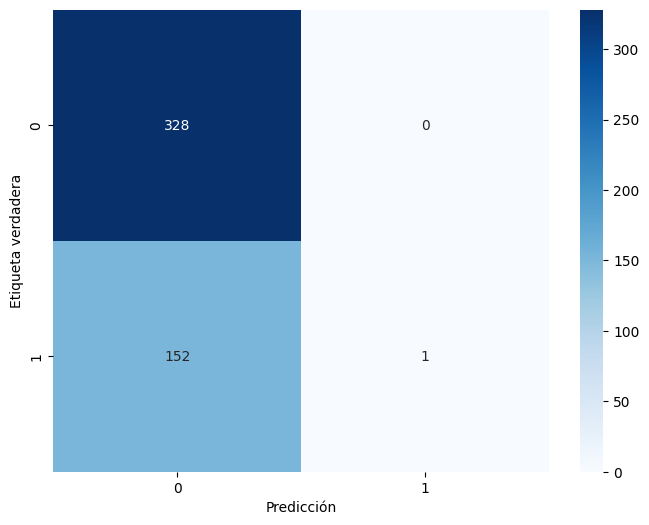

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
              precision    recall  f1-score   support

           0     0.4444    0.3636    0.4000        22
           1     0.5882    0.6667    0.6250        30

    accuracy                         0.5385        52
   macro avg     0.5163    0.5152    0.5125        52
weighted avg     0.5274    0.5385    0.5298        52



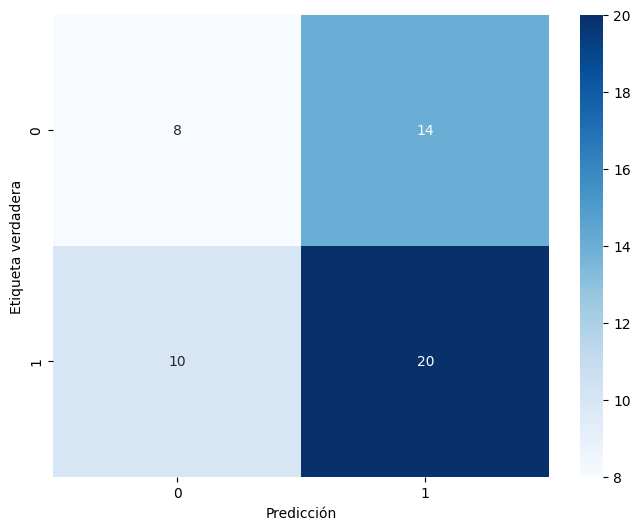

In [12]:
# Carga de pesos
model.load_weights('best_model.keras')
# Obtén el diccionario original {etiqueta_str: índice_entero}
evaluate_model(model, regression=regression, generator=val_gen)
model.load_weights('best_model_cat.keras')
evaluate_model(model, regression=regression, generator=cat_gen)

=== Historial de entrenamiento ===
accuracy: [0.5597239136695862, 0.5993397235870361, 0.6290516257286072, 0.6212484836578369, 0.6476590633392334, 0.6329531669616699, 0.6557623147964478, 0.6593637466430664, 0.6623649597167969, 0.6737695336341858, 0.6695678234100342, 0.6752700805664062, 0.6848739385604858, 0.6809723973274231, 0.6842737197875977, 0.6827731132507324, 0.679771900177002, 0.6839736104011536, 0.6854742169380188, 0.6809723973274231, 0.6824730038642883, 0.6818727254867554, 0.6893757581710815, 0.6845738291740417, 0.6842737197875977, 0.6845738291740417, 0.6857743263244629, 0.6809723973274231, 0.6827731132507324, 0.6863745450973511, 0.6854742169380188, 0.6848739385604858, 0.6845738291740417, 0.6842737197875977, 0.6857743263244629, 0.6845738291740417, 0.6863745450973511, 0.6848739385604858, 0.6824730038642883, 0.6854742169380188, 0.6863745450973511, 0.6863745450973511, 0.6845738291740417, 0.6872749328613281, 0.6848739385604858, 0.6839736104011536, 0.6872749328613281, 0.6851740479469

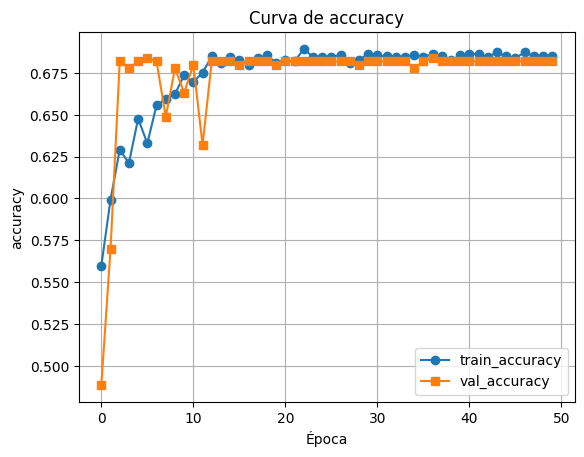

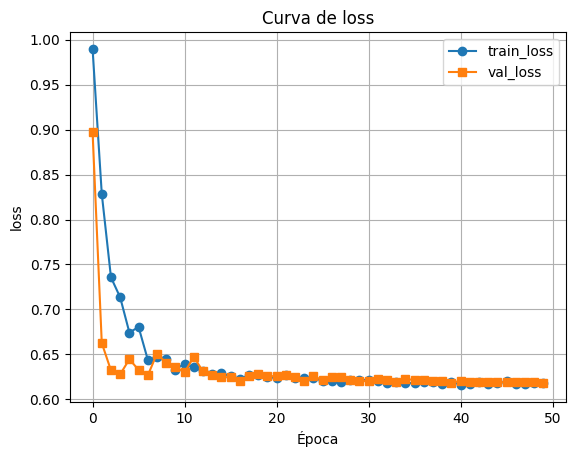

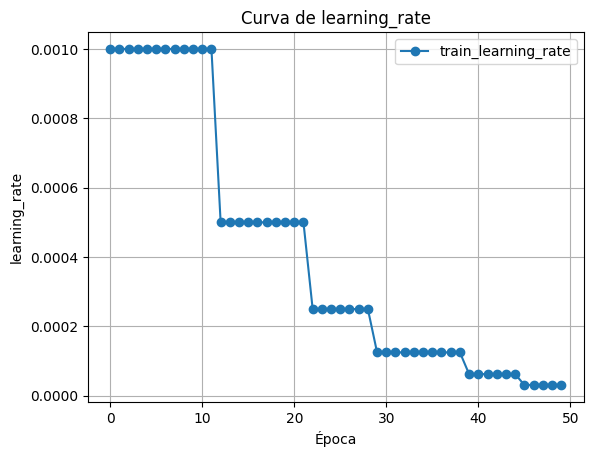

In [13]:
print("=== Historial de entrenamiento ===")
for metric_name, metric_values in history.history.items():
    print(f"{metric_name}: {metric_values}")

# 2. (Opcional) Graficar las curvas de entrenamiento y validación
import matplotlib.pyplot as plt

# Determinar qué métricas hay (loss, mae o accuracy, val_loss, val_mae o val_accuracy)
keys = list(history.history.keys())

# Para cada métrica de entrenamiento sin prefijo 'val_'
for k in keys:
    if not k.startswith('val_'):
        plt.figure()
        plt.plot(history.history[k], marker='o', label=f'train_{k}')
        val_key = f'val_{k}'
        if val_key in history.history:
            plt.plot(history.history[val_key], marker='s', label=f'val_{k}')
        plt.title(f'Curva de {k}')
        plt.xlabel('Época')
        plt.ylabel(k)
        plt.legend()
        plt.grid(True)
        plt.show()

=== Historial de validación de gatos ===
Época 1: Loss/MAE = 0.7980, Accuracy = 0.5385
Época 2: Loss/MAE = 0.7276, Accuracy = 0.4231
Época 3: Loss/MAE = 0.9568, Accuracy = 0.4231
Época 4: Loss/MAE = 0.9015, Accuracy = 0.4231
Época 5: Loss/MAE = 0.9203, Accuracy = 0.4231
Época 6: Loss/MAE = 0.8309, Accuracy = 0.4231
Época 7: Loss/MAE = 0.8356, Accuracy = 0.4231
Época 8: Loss/MAE = 0.8610, Accuracy = 0.4231
Época 9: Loss/MAE = 0.8369, Accuracy = 0.4231
Época 10: Loss/MAE = 0.7953, Accuracy = 0.4231
Época 11: Loss/MAE = 0.8161, Accuracy = 0.4231
Época 12: Loss/MAE = 0.8981, Accuracy = 0.4231
Época 13: Loss/MAE = 0.9040, Accuracy = 0.4231
Época 14: Loss/MAE = 0.8786, Accuracy = 0.4231
Época 15: Loss/MAE = 0.8886, Accuracy = 0.4231
Época 16: Loss/MAE = 0.9041, Accuracy = 0.4231
Época 17: Loss/MAE = 0.9045, Accuracy = 0.4231
Época 18: Loss/MAE = 0.8483, Accuracy = 0.4231
Época 19: Loss/MAE = 0.8796, Accuracy = 0.4231
Época 20: Loss/MAE = 0.9263, Accuracy = 0.4231
Época 21: Loss/MAE = 0.8932,

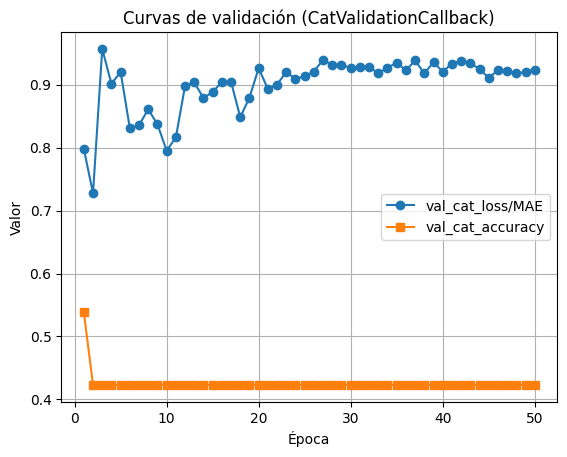

In [14]:
cat_callback = callbacks[2]

print("=== Historial de validación de gatos ===")
for m in cat_callback.epoch_metrics:
    epoch = m['epoch']
    loss = m['val_cat_loss']
    acc  = m['val_cat_accuracy']
    print(f"Época {epoch}: Loss/MAE = {loss:.4f}, Accuracy = {acc:.4f}")

# (Opcional) Graficar la evolución de loss y accuracy de validación de gatos
import matplotlib.pyplot as plt

epochs = [m['epoch'] for m in cat_callback.epoch_metrics]
losses = [m['val_cat_loss'] for m in cat_callback.epoch_metrics]
accs   = [m['val_cat_accuracy'] for m in cat_callback.epoch_metrics]

plt.figure()
plt.plot(epochs, losses, marker='o', label='val_cat_loss/MAE')
plt.plot(epochs, accs,   marker='s', label='val_cat_accuracy')
plt.title('Curvas de validación (CatValidationCallback)')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

# Anterior

## Exploración del dataset de artrosis de rodilla

- **Total de imágenes:** 9 786

| Partición      | Imágenes | Porcentaje |
|---------------|---------:|-----------:|
| **Train**      | 5 778    | 59.04 %    |
| **Validation** |   826    |  8.44 %    |
| **Test**       | 1 656    | 16.92 %    |
| **AutoTest**   | 1 526    | 15.59 %    |


### Distribución de clases en `Train`

|  Clase  | Índice | Imágenes | Porcentaje |
|---------|-------:|---------:|-----------:|
| Sin     |      0 |    2 286 |     39.56 % |
| Ligera  |      1 |    1 046 |     18.10 % |
| Leve    |      2 |    1 516 |     26.24 % |
| Moderada|      3 |      757 |     13.10 % |
| Severa  |      4 |      173 |      2.99 % |

